# Sigmoid Change Point Model

We build a time series model of the number mining disasters after a change in the law.
Unlike discrete changepoint models this model is continuous; it uses a generalised
sigmoid as a function of time to calculate the disaster rate for each year.

In [1]:
import jax
import jax.numpy as jnp

import numpyro
import numpyro.infer
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS

import arviz as az

import numpy
import scipy.special
import scipy.stats

from IPython.display import set_matplotlib_formats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# hard code example coal mining disaster dataset

D = jnp.array([
     4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
     2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
     3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
     dtype=jnp.int32)

N = len(D)
t = jnp.arange(N)                # number of years from the start of the data
t_pres = jnp.arange(1851, 1962)  # real years for presentation in plots

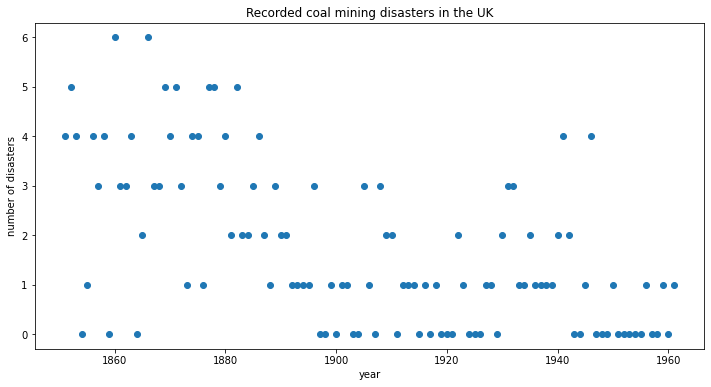

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Recorded coal mining disasters in the UK")
ax.set_ylabel("number of disasters")
ax.set_xlabel("year")
plt.scatter(t_pres, D);

In [4]:
def gen_sigmoid(A, K, B, M, t):
    """
    A generalised sigmoid function

    :param A: starting value (left asymptote)
    :param K: ending value (right asymptote)
    :param B: speed of change (larger values faster change)
    :param M: time of change midpoint (location parameter)
    :param t: input value
    :returns: value of function at t
    """
    return A + ((K - A) / (1. + jnp.exp(-B*(t - M))))

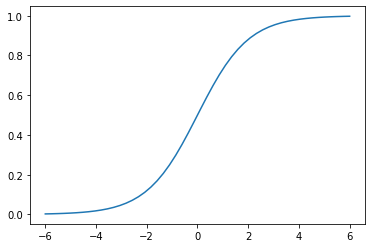

In [5]:
# plot generalised sigmoid with parameters for the standard sigmoid

def plot():
    t = jnp.linspace(-6., 6.)
    x = gen_sigmoid(A=0., K=1., B=1., M=0, t=t)
    plt.plot(t, x)

plot()

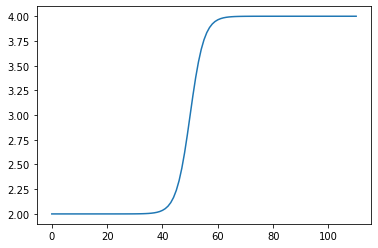

In [6]:
# plot generalised sigmoid with other example parameters

def plot():
    t = jnp.arange(N)
    x = gen_sigmoid(A=2., K=4., B=0.4, M=50., t=t)
    plt.plot(t, x)

plot()

In [7]:
# define the numpyro model function

def continuous_change_point(N, t=None, D=None):
    rate_early  = numpyro.sample('rate_early',  dist.Exponential(1.)) # early disaster rate (disasters / year)
    rate_late   = numpyro.sample('rate_late',   dist.Exponential(1.)) # late disaster rate  (disasters / year)
    rate_scale  = numpyro.sample('rate_scale',  dist.HalfNormal(0.2)) # speed of change     (1 / year)
    rate_change = numpyro.sample('rate_change', dist.Uniform(0, N))   # change mid-point    (year)
    rate_t      = numpyro.deterministic('rate_t',
                    gen_sigmoid(A=rate_early, K=rate_late, B=rate_scale, M=rate_change, t=t))
                    # compute the disaster rate for each time and save the value
    with numpyro.plate('N', N):
        numpyro.sample('obs', dist.Poisson(rate_t), obs=D) # observe disaster counts from a poisson distribution

In [8]:
nuts_kernel = NUTS(continuous_change_point, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_chains=1, num_warmup=1000, num_samples=4000)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, N=N, t=t, D=D, extra_fields=('energy', 'potential_energy',))

sample: 100%|█| 5000/5000 [00:15<00:00, 325.28it/s, 7 steps of size 5.55e-01. ac


In [9]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  rate_change     37.51      3.36     37.65     32.24     42.85   2422.30      1.00
   rate_early      3.29      0.35      3.27      2.70      3.82   2622.60      1.00
    rate_late      0.88      0.12      0.88      0.67      1.06   3773.36      1.00
   rate_scale      0.26      0.11      0.25      0.10      0.43   2764.26      1.00

Number of divergences: 0


In [10]:
# export samples into ArViz for visualisation
ds = az.from_numpyro(mcmc)

In [11]:
ds.posterior

<xarray.Dataset>
Dimensions:       (chain: 1, draw: 4000, rate_t_dim_0: 111)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * rate_t_dim_0  (rate_t_dim_0) int64 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
Data variables:
    rate_change   (chain, draw) float32 34.71 39.36 36.7 ... 38.05 35.85 39.92
    rate_early    (chain, draw) float32 3.624 3.478 3.262 ... 3.05 3.17 3.303
    rate_late     (chain, draw) float32 0.8782 0.732 0.8688 ... 1.082 0.7739
    rate_scale    (chain, draw) float32 0.3 0.2615 0.2507 ... 0.2999 0.2305
    rate_t        (chain, draw, rate_t_dim_0) float32 3.624 3.624 ... 0.7739
Attributes:
    created_at:                 2022-03-16T08:39:21.266737
    arviz_version:              0.11.4
    inference_library:          numpyro
    inference_library_version:  0.9.1

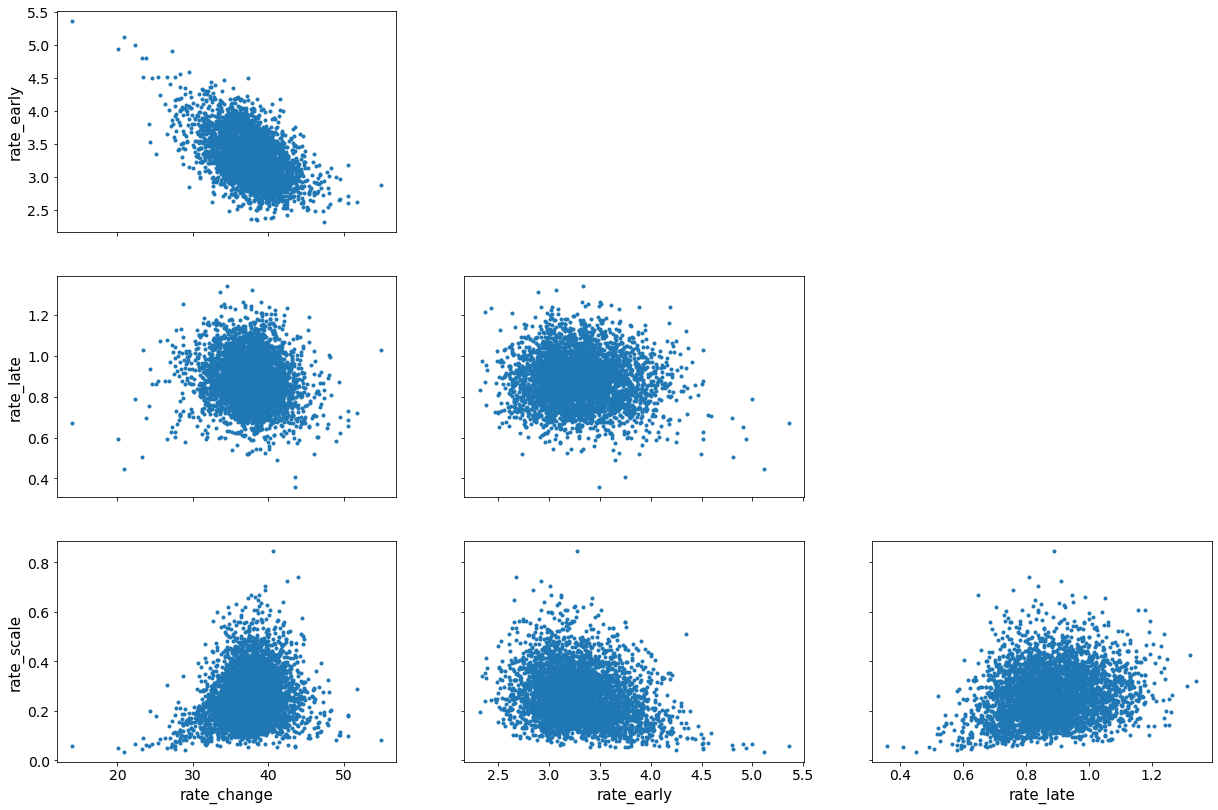

In [12]:
param_vars = ['rate_change', 'rate_early', 'rate_late', 'rate_scale']

az.plot_pair(ds,
             var_names=param_vars,
             divergences=True)

plt.show()

array([[<AxesSubplot:title={'center':'rate_change'}>,
        <AxesSubplot:title={'center':'rate_early'}>,
        <AxesSubplot:title={'center':'rate_late'}>],
       [<AxesSubplot:title={'center':'rate_scale'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

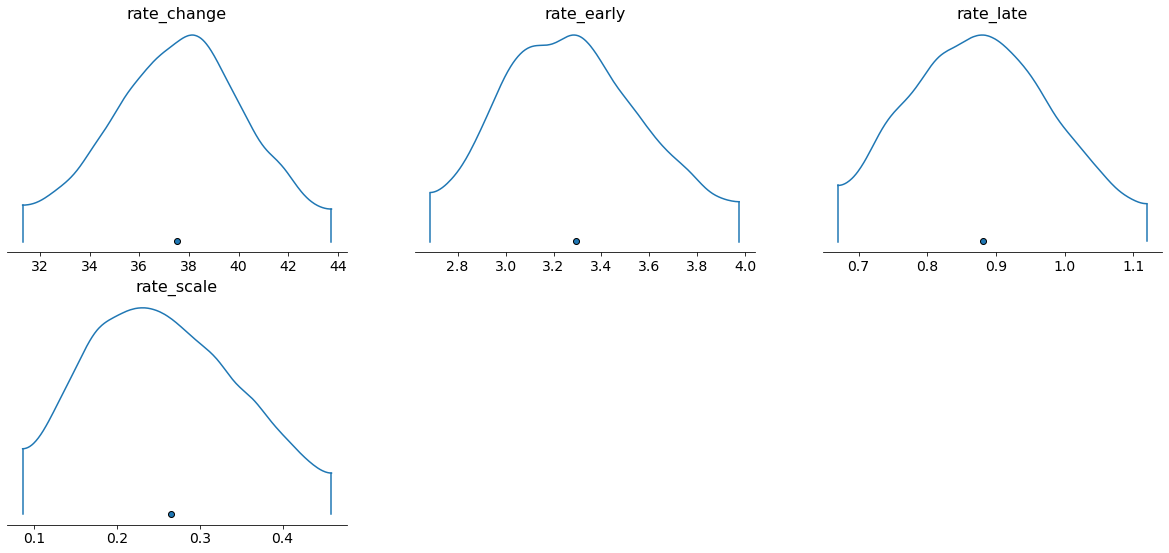

In [13]:
az.plot_density(ds.posterior, var_names=param_vars)

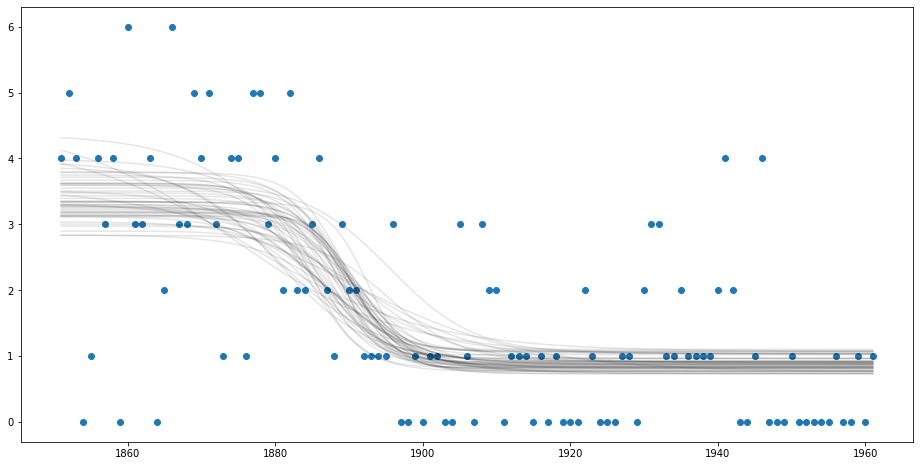

In [14]:
# show the first 50 samples as overlayed transparent lines
n_samples = 50
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(t_pres, D)
plt.plot(t_pres, ds.posterior.rate_t[0, :n_samples].T, color='k', alpha=0.1);

In [15]:
', '.join([ m for m in dir(az) if not m.startswith('_')])

'ColumnDataSource, CoordSpec, Dask, DimSpec, ELPDData, InferenceData, Numba, PyStan2SamplingWrapper, PyStanSamplingWrapper, SamplingWrapper, apply_test_function, autocorr, autocov, bfmi, clear_data_home, compare, concat, convert_to_dataset, convert_to_inference_data, create_layout, data, dict_to_dataset, ess, from_cmdstan, from_cmdstanpy, from_dict, from_emcee, from_json, from_netcdf, from_numpyro, from_pyjags, from_pymc3, from_pymc3_predictions, from_pyro, from_pystan, from_tfp, hdi, interactive_backend, kde, labels, list_datasets, load_arviz_data, loo, loo_pit, make_ufunc, mcse, numpy_to_data_array, output_file, output_notebook, plot_autocorr, plot_bpv, plot_compare, plot_density, plot_dist, plot_dist_comparison, plot_dot, plot_elpd, plot_energy, plot_ess, plot_forest, plot_hdi, plot_joint, plot_kde, plot_khat, plot_lm, plot_loo_pit, plot_mcse, plot_pair, plot_parallel, plot_posterior, plot_ppc, plot_rank, plot_separation, plot_trace, plot_ts, plot_violin, plots, psislw, r2_score, rc

<AxesSubplot:>

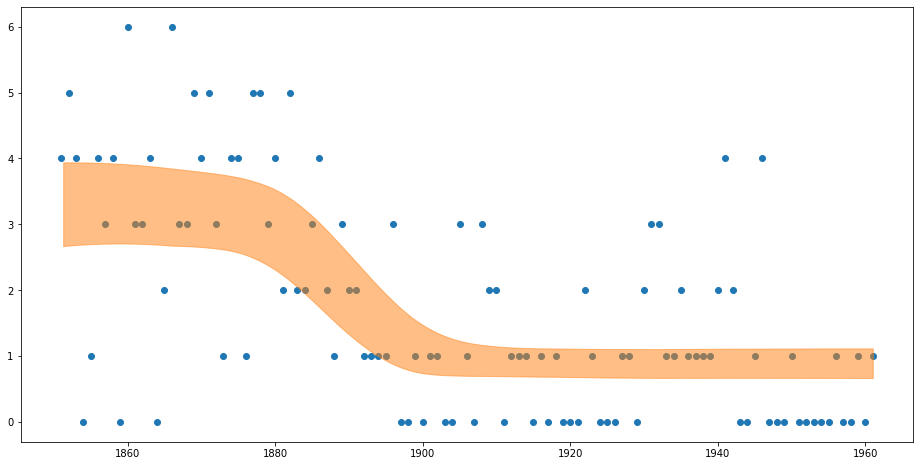

In [16]:
# show the highest density interval at each year (~95% of sampled sigmoids should fall within this region)
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(t_pres, D)
az.plot_hdi(t_pres, ds.posterior.rate_t)

In [17]:
t_change = ds.posterior.rate_change + t_pres[0]
float(numpy.mean(t_change))

1888.5137939453125

In [18]:
float(numpy.mean(ds.posterior.rate_late - ds.posterior.rate_early))

-2.413069009780884

In [19]:
t_change = ds.posterior.rate_change + t_pres[0]
float(numpy.mean(numpy.logical_and(t_change > 1890, t_change < 1900)))

0.30975